In [16]:
# Setup scenario
import json
from pathlib import Path
from time import time

import geopandas as gpd
import fiona
import numpy as np
import pandas as pd
import pycountry
import shapely
from shapely.geometry import Point


from climada.util.api_client import Client
from climada.entity import Exposures, LitPop
from climada.entity.impact_funcs import ImpactFunc, ImpactFuncSet, ImpfTropCyclone
from climada.hazard import Hazard
from climada.engine import Impact, ImpactCalc
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity.impact_funcs.trop_cyclone import ImpfSetTropCyclone

from handlers import calculate_impact, calculate_impact_function_set, get_exposure_new, get_hazard_new, get_iso3_country_code
from logger_config import LoggerConfig

logger = LoggerConfig(logger_types=["file"])


notebook_dir = %pwd

# Go up one directory
BASE_DIR = Path(notebook_dir).parent

# Define the paths for exposures and hazards
DATA_DIR = BASE_DIR / "data"
EXPOSURES_DIR = BASE_DIR / "data" / "exposures"
HAZARDS_DIR = BASE_DIR / "data" / "hazards"
REQUIREMENTS_DIR = BASE_DIR / "requirements"
GADM41_EGY_PATH = REQUIREMENTS_DIR / "gadm41_EGY.gpkg"
GADM41_THA_PATH = REQUIREMENTS_DIR / "gadm41_THA.gpkg"
TEMP_DIR = DATA_DIR / "temp" 

# Available Exposure data types in CLIMADA API for Egypt/Thailand: ['litpop']
# Available Hazard data types in CLIMADA API for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
# Available climate scenarios for hazard type river_flood/tropical_c in country Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
# Available time horizons for hazard type river_flood in country Egypt: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070']

country_name = "Egypt"
exposure_type = "litpop"        # Available exposure types for Egypt/Thailand: ['litpop']
hazard_type = "river_flood"     # Available hazard types for Egypt/Thailand: ['river_flood', 'wildfire', 'earthquake', 'flood', 'tropical_cyclone']
climate_scenario = "rcp26" # Available scenarios for Egypt/Thailand: ['rcp26', 'historical', 'rcp60', 'rcp85']
time_horizon = "2030_2050"      # Available time horizons for Egypt/Thailand: ['2030_2050', '1980_2000', '2070_2090', '2010_2030', '2050_2070'] / 


client = Client()

In [ ]:
# List DataTypeInfos
data_type_infos = client.list_data_type_infos()
exposure_data_types = [data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'exposures']
hazard_data_types = [data_type_info.data_type for data_type_info in data_type_infos if data_type_info.data_type_group == 'hazard']

print(f'Available Exposure data types in CLIMADA API for all countries:\n{exposure_data_types}')
print(f'Available Hazard data types in CLIMADA API for all countries:\n{hazard_data_types}')

In [ ]:
# Available country Exposures and Hazard data types
dataset_infos = client.list_dataset_infos(
    properties={
        'country_name': country_name,
    }
)

exposure_data_types= list(set([dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'exposures']))
hazard_data_types = list(set([dataset_info.data_type.data_type for dataset_info in dataset_infos if dataset_info.data_type.data_type_group == 'hazard']))

print(f'Available Exposure data types in CLIMADA API for {country_name}: {exposure_data_types}')
print(f'Available Hazard data types in CLIMADA API for {country_name}: {hazard_data_types}')

In [ ]:
if hazard_type == 'river_flood' or 'wildfire':
    available_scenarios = list(set([dataset_info.properties['climate_scenario'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties['year_range'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'tropical_cyclone':
    available_scenarios = list(set([dataset_info.properties['climate_scenario'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
    available_time_horizons = list(set([dataset_info.properties.get('ref_year') for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))
if hazard_type == 'earthquake':
    available_scenarios = []
    available_time_horizons = []
if hazard_type == 'flood':
    available_scenarios = []
    available_time_horizons = list(set([dataset_info.properties['year_range'] for dataset_info in dataset_infos if dataset_info.data_type.data_type == hazard_type]))

print(f'Available climate scenarios for hazard type {hazard_type} in country {country_name}: {available_scenarios}')
print(f'Available time horizons for hazard type {hazard_type} in country {country_name}: {available_time_horizons}')

In [ ]:
# Available country Hazard DatasetInfos
hazard_dataset_infos = client.list_dataset_infos(
    properties={
        'data_type': hazard_type,
        'country_name': country_name,
        'climate_scenario': climate_scenario
    }
)
hazard_dataset_infos

In [12]:
# Get Exposure and Exposure gdf
# Available Exposures: ['litpop']
exposure = get_exposure_new(country=country_name)
exposure_gdf = exposure.gdf
# exposure_gdf

2023-12-07 17:48:49,966 - climada.util.api_client - WARNING - there is no internet connection but the client has stored the results of this very request sometime in the past.


In [13]:
# Get Hazard
# Available Hazards: ['river_flood', 'tropical_cyclone', 'wildfire', 'flood', 'earthquake']
hazard = get_hazard_new(
    hazard_type=hazard_type,
    scenario=climate_scenario,
    time_horizon=time_horizon,
    country=country_name
)

In [14]:
# Get Impact
impact_function_set = calculate_impact_function_set(
    hazard=hazard, impact_function_name="Flood Africa JRC Residential"
)
impact = calculate_impact(exposure, hazard, impact_function_set)

In [18]:
hazard.centroids.coord

array([[31.625     , 25.125     ],
       [31.58333333, 25.08333333],
       [31.58333333, 25.125     ],
       ...,
       [22.        , 36.79166667],
       [22.        , 36.83333333],
       [22.        , 36.875     ]])

In [22]:
coords = np.array(impact.coord_exp)
local_exceedance_inten = impact.local_exceedance_imp((25,))
local_exceedance_inten

array([[7.25783364e-05, 1.30610171e-05, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [28]:
def generate_impact_geojson(
    impact: Impact, country_name: str, return_periods: tuple = (250, 100, 50, 10)
):
    try:
        country_iso3 = get_iso3_country_code(country_name)
        GADM41_filename = Path(REQUIREMENTS_DIR) / f"gadm41_{country_iso3}.gpkg"

        admin_gdf = gpd.read_file(filename=GADM41_filename, layer=2)
        coords = np.array(impact.coord_exp)
        local_exceedance_imp = impact.local_exceedance_imp(return_periods)
        local_exceedance_imp = pd.DataFrame(local_exceedance_imp).T
        data = np.column_stack((coords, local_exceedance_imp))
        columns = ["longitude", "latitude"] + [f"rp{rp}" for rp in return_periods]
        impact_gdf = gpd.GeoDataFrame(
            pd.DataFrame(data, columns=columns),
            geometry=gpd.points_from_xy(data[:, 0], data[:, 1]),
        )
        impact_gdf.set_crs("EPSG:4326", inplace=True)

        # Filter hazard_gdf to exclude rows where all return period values are zero
        impact_gdf = impact_gdf[(impact_gdf[[f"rp{rp}" for rp in return_periods]] != 0).any(axis=1)]
        impact_gdf = impact_gdf.drop(columns=["latitude", "longitude"])
        impact_gdf = impact_gdf.reset_index(drop=True)

        # Spatial join with administrative areas
        joined_gdf = gpd.sjoin(impact_gdf, admin_gdf, how="left", predicate="within")
        # Convert to GeoJSON for this layer and add to all_layers_geojson
        impact_geojson = joined_gdf.__geo_interface__

        # Save the combined GeoJSON file
        map_data_filepath = TEMP_DIR / f"risks_geodata.json"
        with open(map_data_filepath, "w") as f:
            json.dump(impact_geojson, f)
    except Exception as exception:
        logger.log("debug", f"An unexpected error occurred. More info: {exception}")


generate_impact_geojson(impact, country_name)

(<GeoAxesSubplot:title={'center':'Return period: 25 years'}>,
 array([[7.25783364e-05, 1.30610171e-05, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]))

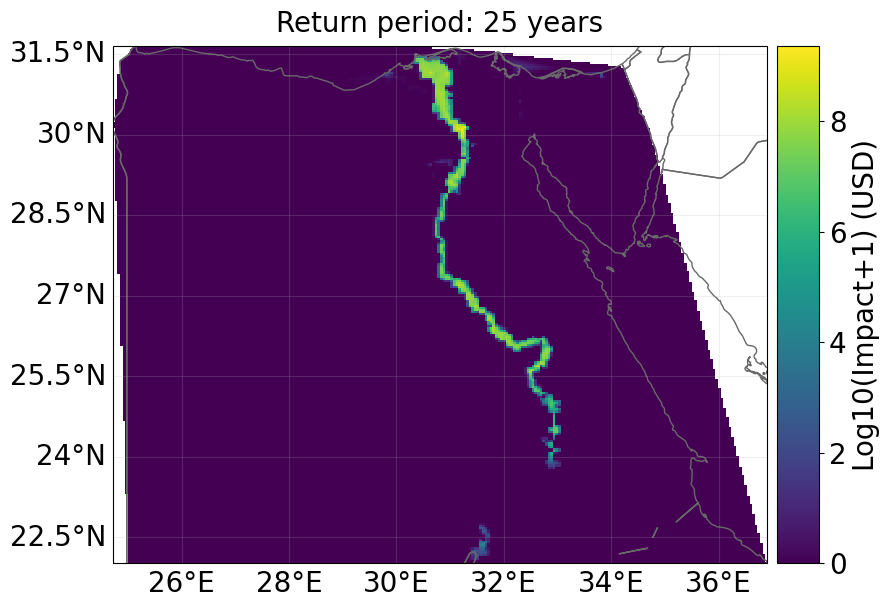

In [15]:
impact.plot_rp_imp((25,))